<a href="https://colab.research.google.com/github/aspiringastro/practical_deep_learning/blob/main/Is_it_a_bird.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:


# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities

!pip install fastai duckduckgo_search

  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.


In [4]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [5]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('bird photos', max_images=1)
urls[0]

Searching for 'bird photos'


'http://hdqwalls.com/wallpapers/colorful-parrot-bird.jpg'

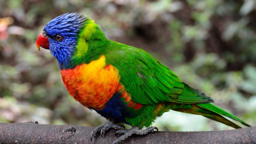

In [6]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'WWII plane'


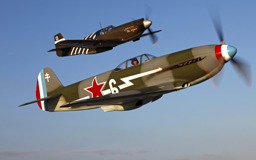

In [7]:
download_url(search_images('WWII plane', max_images=1)[0], 'plane.jpg', show_progress=False)
Image.open('plane.jpg').to_thumb(256,256)

In [8]:
searches = 'WWII plane','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} flying photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'WWII plane photo'
Searching for 'WWII plane sun photo'
Searching for 'WWII plane shade photo'
Searching for 'WWII plane flying photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'
Searching for 'bird flying photo'


In [9]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

3

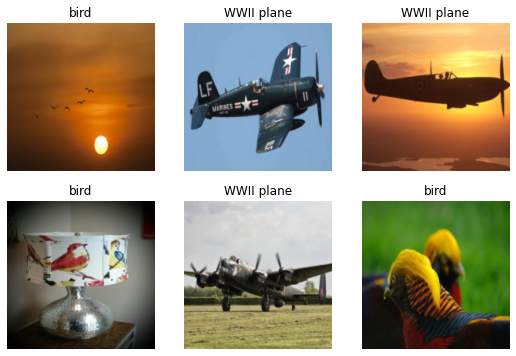

In [10]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [11]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.141388,0.237855,0.111111,00:25


epoch,train_loss,valid_loss,error_rate,time
0,0.195047,0.040688,0.000000,00:37
1,0.118908,0.020531,0.000000,00:36


epoch,train_loss,valid_loss,error_rate,time
0,0.195047,0.040688,0.000000,00:37
1,0.118908,0.020531,0.000000,00:36
2,0.076966,0.019415,0.000000,00:40
3,0.056806,0.027577,0.000000,00:36
4,0.044152,0.030981,0.000000,00:36


In [13]:
im = Image.open('bird.jpg')
im.to_thumb(256,256)
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

im = Image.open('plane.jpg')
im.to_thumb(256,256)
is_plane,_,probs = learn.predict(PILImage.create('plane.jpg'))
print(f"This is a: {is_plane}.")
print(f"Probability it's a plane: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 0.0000


This is a: WWII plane.
Probability it's a plane: 0.9999
